In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import explore

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

from wrangle import wrangle_zillow_mvp, wrangle_zillow, get_zillow_mvp, prepare_zillow_mvp

# Shhhh
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = get_zillow_mvp()

In [3]:
df.info(), df.shape
# Without it dropping 0 bedrooms and pulling the one entry that doesn't have a 2017 date as well,
# we get the 52,442 (0 - 52,411 indexs)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52305 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   52305 non-null  float64
 1   bathrooms  52305 non-null  float64
 2   area       52297 non-null  float64
 3   tax_value  52304 non-null  float64
 4   date       52305 non-null  object 
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


(None, (52305, 5))

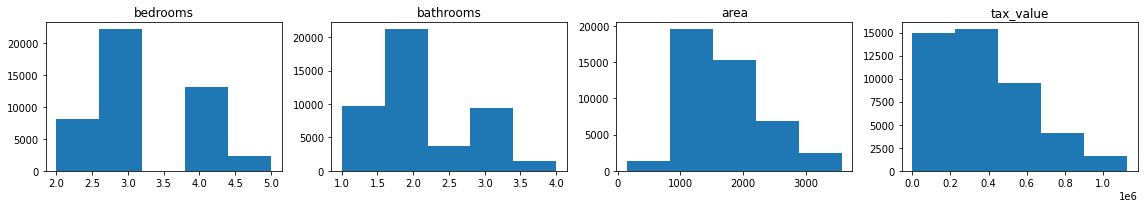

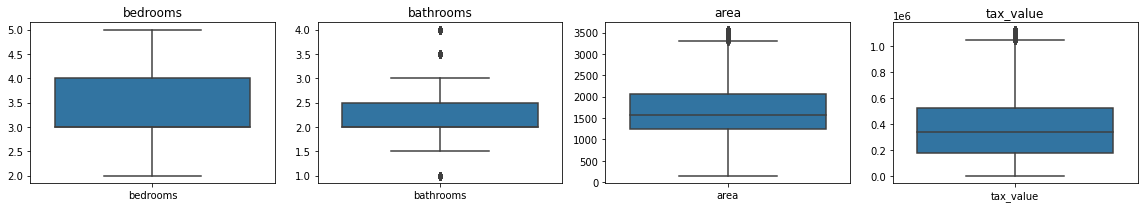

In [4]:
train, validate, test = prepare_zillow_mvp(df)

In [5]:
# All nulls have been cleared from the data and it's been split into Train, Validate, And Test.
# Time to check the full function.

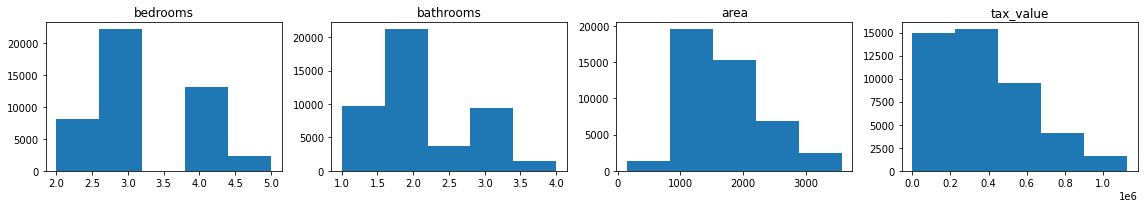

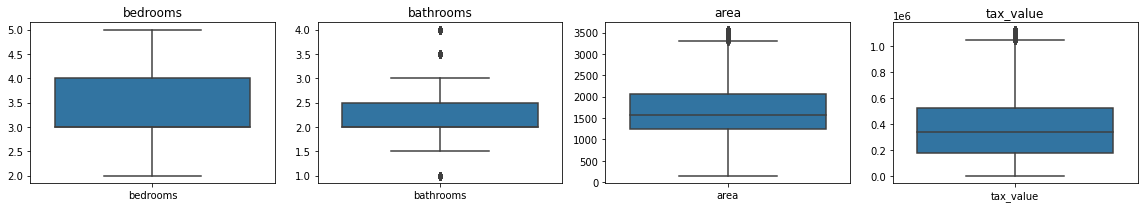

In [6]:
train, validate, test = wrangle_zillow_mvp()

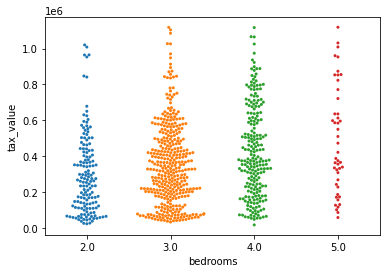

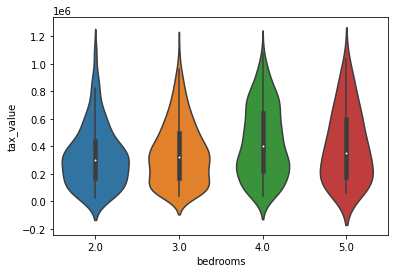

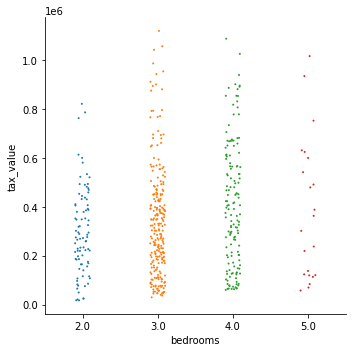

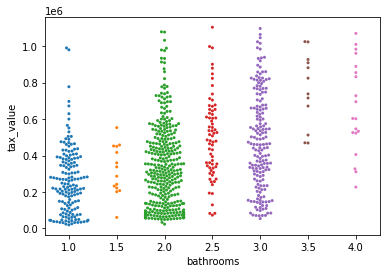

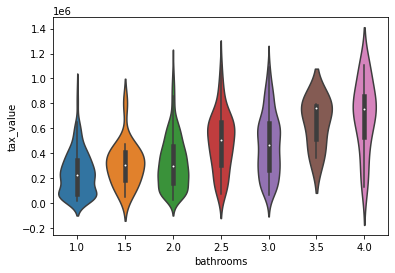

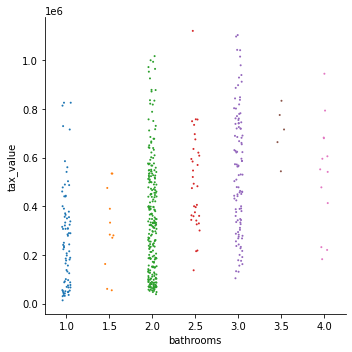

In [7]:
explore.plot_categorical_and_continuous_vars(train)

-=== bedrooms ===-
 
Value Counts:
-------------
3.0    12383
4.0     7262
2.0     4555
5.0     1350
Name: bedrooms, dtype: int64
 
Percent of Total:
-----------------
3.0    48.465753
4.0    28.422701
2.0    17.827789
5.0     5.283757
Name: bedrooms, dtype: float64
 
 >> P is less than Alpha.
 


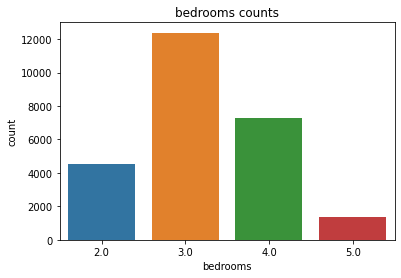

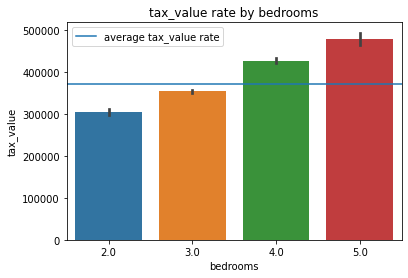

 
 
-=== bathrooms ===-
 
Value Counts:
-------------
2.0    11897
3.0     5302
1.0     4942
2.5     2068
4.0      595
1.5      487
3.5      259
Name: bathrooms, dtype: int64
 
Percent of Total:
-----------------
2.0    46.563601
3.0    20.751468
1.0    19.342466
2.5     8.093933
4.0     2.328767
1.5     1.906067
3.5     1.013699
Name: bathrooms, dtype: float64
 
 >> P is less than Alpha.
 


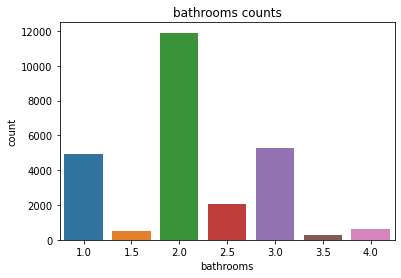

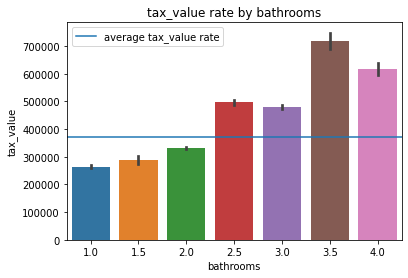

In [8]:
explore.explore_cat(train)